In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import csv
from skimage.measure import label, regionprops
import matplotlib.patches as patches

In [2]:
root_main = '//zkh/appdata/RTDicom/DAMEproject/LUNGSABR_data_2022/NIFTI_v0'
#root_main = '//zkh/appdata/RTDicom/DAMEproject/LungSABR_data/Dicom data renamed Nifti/MultipleBreathingP'
root_save = 'C:/Users/delaOArevaLR/OneDrive - UMCG/Code/Chapter1/ImagesFromScripts/ITV-GTV-SizeDifferences/'

In [3]:
def display_Fun(struct,image,views_itv,views_gtv,bbox_itv,bbox_gtv,path2save):
    if not(os.path.exists(path2save)):
        os.mkdir(path2save)
    midSlice_x, midSlice_y, midSlice_z = MidTumorSliceFinder(itv)

    minrow,maxrow,mincol,maxcol = bbox_itv[0],bbox_itv[1],bbox_itv[4],bbox_itv[5]
    minrow_g,maxrow_g,mincol_g,maxcol_g = bbox_gtv[0],bbox_gtv[1],bbox_gtv[4],bbox_gtv[5]
    plt.imshow((ct[midSlice_x,:,:]),cmap='gray'),plt.axis('off')
    #plt.contour(np.rot90(views_itv[0]-views_gtv[0])),plt.axis('off')#,plt.show()
    plt.contour((views_itv[0]),colors='r'),plt.axis('on')#,plt.show()
    #plt.contour((views_gtv[0]),colors='b')
    plt.gca().add_patch(patches.Rectangle((mincol,minrow),maxcol-mincol,maxrow-minrow,linewidth=1,edgecolor='r',facecolor='white'))
    #plt.gca().add_patch(patches.Rectangle((mincol_g,minrow_g),maxcol_g-mincol_g,maxrow_g-minrow_g,linewidth=1,edgecolor='b',facecolor='blue'))
    plt.savefig(path2save+"/X.png"),plt.clf()

    minrow,maxrow,mincol,maxcol = bbox_itv[2],bbox_itv[3],bbox_itv[4],bbox_itv[5]
    minrow_g,maxrow_g,mincol_g,maxcol_g = bbox_gtv[2],bbox_gtv[3],bbox_gtv[4],bbox_gtv[5]
    plt.imshow((ct[:,midSlice_y,:]),cmap='gray'),plt.axis('off')
    #plt.contour(np.rot90(views_itv[1]-views_gtv[1])),plt.axis('off')
    plt.contour((views_itv[1]),colors='r'),plt.axis('on')#,plt.show()
    #plt.contour((views_gtv[1]),colors='b')
    #plt.gca().add_patch(patches.Rectangle((mincol,minrow),maxcol-mincol,maxrow-minrow,linewidth=1,edgecolor='r',facecolor='white'))
    plt.gca().add_patch(patches.Rectangle((mincol_g,minrow_g),maxcol_g-mincol_g,maxrow_g-minrow_g,linewidth=1,edgecolor='b',facecolor='blue'))
    plt.savefig(path2save+"/Y.png"),plt.clf()

    minrow,maxrow,mincol,maxcol = bbox_itv[2],bbox_itv[3],bbox_itv[0],bbox_itv[1]
    minrow_g,maxrow_g,mincol_g,maxcol_g = bbox_gtv[2],bbox_gtv[3],bbox_gtv[0],bbox_gtv[1]
    plt.imshow((ct[:,:,midSlice_z]),cmap='gray'),plt.axis('off')
    #plt.contour(np.rot90(views_itv[2]-views_gtv[2],-1)),plt.axis('off')
    plt.contour((views_itv[2]),colors='r'),plt.axis('on')#,plt.show()
    #plt.contour((views_gtv[2]),colors='b')
    plt.gca().add_patch(patches.Rectangle((mincol,minrow),maxcol-mincol,maxrow-minrow,linewidth=1,edgecolor='r',facecolor='white'))
    #plt.gca().add_patch(patches.Rectangle((mincol_g,minrow_g),maxcol_g-mincol_g,maxrow_g-minrow_g,linewidth=1,edgecolor='b',facecolor='blue'))
    plt.savefig(path2save+"/Z.png"),plt.clf()

In [4]:
def MidTumorSliceFinder(struct_np):
    x,y,z = np.where(struct_np!=0)
    midSlice_x = x.min() + (x.max()-x.min())//2
    midSlice_y = y.min() + (y.max()-y.min())//2
    midSlice_z = z.min() + (z.max()-z.min())//2

    return midSlice_x, midSlice_y, midSlice_z

In [5]:
def longest_axis_2d(binary_volume):   
    views = [binary_volume.max(axis=i) for i in range(3)]
    values_row,values_col = [],[]
    bbox_curr = []
    for view in views:
        labeled_view = label(view)
        regions = regionprops(labeled_view)
        minRow,minCol,maxRow,maxCol = 1000,1000,0,0
        #for region in regions:
        largest_region = max(regions, key=lambda region: region.area)
        curr_minRow,curr_minCol,curr_maxRow,curr_maxCol = largest_region.bbox#(row,col)
        if minRow>curr_minRow: minRow=curr_minRow
        if maxRow<curr_maxRow: maxRow=curr_maxRow
        if minCol>curr_minCol: minCol=curr_minCol
        if maxCol<curr_maxCol: maxCol=curr_maxCol

        bbox_curr.append([minRow,maxRow,minCol,maxCol])

        rowDist = maxRow - minRow
        colDist = maxCol - minCol
        
        values_row.append(rowDist)
        values_col.append(colDist)

    bbox3d = bbox_curr[0][0],bbox_curr[0][1],bbox_curr[1][0],bbox_curr[1][1],bbox_curr[0][2],bbox_curr[0][3]
    print("bbox3d",bbox3d)
    print("Full",bbox_curr)
    ventro = values_row[0]
    lateral = values_row[1]
    cranio = values_col[0]
    
    return ventro,lateral,cranio,views,bbox3d

In [6]:
hist_ventro,hist_lateral,hist_cranio = ([],[],[])
hist_ventro_neg,hist_lateral_neg,hist_cranio_neg = ([],[],[])
hist_ventro_true,hist_lateral_true,hist_cranio_true = ([],[],[])
to_csv_res = []
listPx = os.listdir(root_main)
print(len(listPx))
for currPx in listPx:
    for root, dirs, files in os.walk(os.path.join(root_main,currPx)):
        itv,gtv,ct=[],[],[]
        for f in files:
            if 'gtv' in f.lower() and not("igtv" in f.lower()):
                gtv = nib.load(os.path.join(root, f)).get_fdata()
                gtv[gtv>0]=1
            if 'itv' in f.lower() or "igtv" in f.lower():
                itv = nib.load(os.path.join(root, f)).get_fdata()
                itv[itv>0]=1
            #if 'ave' in f.lower() or "50%" in f or ('ct' in f.lower() and not "rtstruct" in f.lower()):
            #    ct = nib.load(os.path.join(root, f)).get_fdata()
    
        if len(gtv)>0 and len(itv)>0:# and len(ct)>0:
            ventro_itv,lateral_itv,cranio_itv,views_itv,bbox_itv = longest_axis_2d(itv)
            ventro_gtv,lateral_gtv,cranio_gtv,views_gtv,bbox_gtv = longest_axis_2d(gtv)
            
            cranio_diff_pos = abs(bbox_itv[1] - bbox_gtv[1])
            ventro_diff_pos = abs(bbox_itv[3] - bbox_gtv[3])
            lateral_diff_pos = abs(bbox_itv[5] - bbox_gtv[5])

            cranio_diff_neg = abs(bbox_itv[0] - bbox_gtv[0])
            ventro_diff_neg = abs(bbox_itv[2] - bbox_gtv[2])
            lateral_diff_neg = abs(bbox_itv[4] - bbox_gtv[4])
            
            hist_cranio.append(cranio_diff_pos)
            hist_ventro.append(ventro_diff_pos)
            hist_lateral.append(lateral_diff_pos)

            hist_cranio_neg.append(cranio_diff_neg)
            hist_ventro_neg.append(ventro_diff_neg)
            hist_lateral_neg.append(lateral_diff_neg)

            if bbox_itv[0]<bbox_gtv[0]: bbox_itv0 = bbox_gtv[0]
            else:bbox_itv0 = bbox_itv[0]
            if bbox_itv[1]<bbox_gtv[1]: bbox_itv1 = bbox_gtv[1]
            else:bbox_itv1 = bbox_itv[1]
            if bbox_itv[2]<bbox_gtv[2]: bbox_itv2 = bbox_gtv[2]
            else:bbox_itv2 = bbox_itv[2]
            if bbox_itv[3]<bbox_gtv[3]: bbox_itv3 = bbox_gtv[3]
            else:bbox_itv3 = bbox_itv[3]
            if bbox_itv[4]<bbox_gtv[4]: bbox_itv4 = bbox_gtv[4]
            else:bbox_itv4 = bbox_itv[4]
            if bbox_itv[5]<bbox_gtv[5]: bbox_itv5 = bbox_gtv[5]
            else:bbox_itv5 = bbox_itv[5]

            cranio_diff_true = abs(bbox_itv1 - bbox_gtv[1]) + abs(bbox_itv0 - bbox_gtv[0])
            ventro_diff_true = abs(bbox_itv3 - bbox_gtv[3]) + abs(bbox_itv2 - bbox_gtv[2])
            lateral_diff_true = abs(bbox_itv5 - bbox_gtv[5]) + abs(bbox_itv4 - bbox_gtv[4])

            hist_cranio_true.append(cranio_diff_true)
            hist_ventro_true.append(ventro_diff_true)
            hist_lateral_true.append(lateral_diff_true)

            to_csv_res.append([currPx,ventro_itv,ventro_gtv,ventro_diff_true,lateral_itv,lateral_gtv,lateral_diff_true,cranio_itv,cranio_gtv,cranio_diff_true])
            #to_csv_res.append([currPx,ventro_itv,ventro_gtv,ventro_diff,lateral_itv,lateral_gtv,lateral_diff,cranio_itv,cranio_gtv,cranio_diff])
            #display_Fun(itv,ct,views_itv,views_gtv,bbox_itv,bbox_gtv,os.path.join(root_save,currPx))
            break
            
if False:
    with open(os.path.join(root_save,'DifferencesPerPX_v5.csv'),'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerows(to_csv_res)

100
bbox3d (267, 290, 221, 246, 132, 145)
Full [[267, 290, 132, 145], [221, 246, 132, 145], [221, 246, 267, 290]]
bbox3d (268, 288, 222, 245, 135, 145)
Full [[268, 288, 135, 145], [222, 245, 135, 145], [222, 245, 268, 288]]
bbox3d (283, 312, 323, 351, 152, 164)
Full [[283, 312, 152, 164], [323, 351, 152, 164], [323, 351, 283, 312]]
bbox3d (283, 311, 323, 350, 153, 164)
Full [[283, 311, 153, 164], [323, 350, 153, 164], [323, 350, 283, 311]]
bbox3d (188, 212, 174, 191, 108, 117)
Full [[188, 212, 108, 117], [174, 191, 108, 117], [174, 191, 188, 212]]
bbox3d (189, 211, 174, 190, 108, 117)
Full [[189, 211, 108, 117], [174, 190, 108, 117], [174, 190, 189, 211]]
bbox3d (235, 251, 265, 283, 138, 143)
Full [[235, 251, 138, 143], [265, 283, 138, 143], [265, 283, 235, 251]]
bbox3d (237, 250, 270, 283, 138, 143)
Full [[237, 250, 138, 143], [270, 283, 138, 143], [270, 283, 237, 250]]
bbox3d (261, 278, 147, 162, 97, 106)
Full [[261, 278, 97, 106], [147, 162, 97, 106], [147, 162, 261, 278]]
bbox3d (2

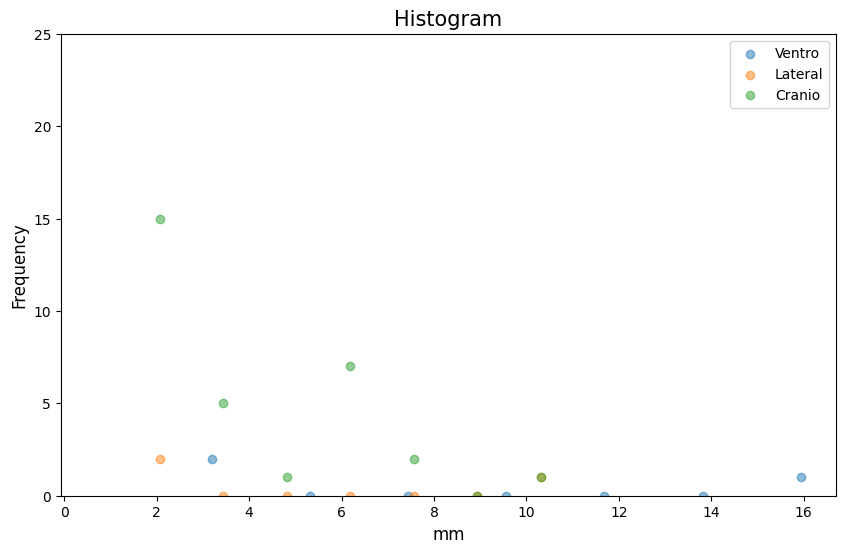

In [7]:
def plot_histogram(datasets, labels, title='Histogram', xlabel='mm', ylabel='Frequency'):  
    np.linspace(min(min(data) for data in datasets), max(max(data) for data in datasets), 15)
    plt.figure(figsize=(10,6))
    bins=8
    for data, label in zip(datasets, labels):
        y, binEdges = np.histogram(data, bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        plt.scatter(bincenters, y, alpha=0.5, label=label)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.ylim([0, 25])  # Set the limit of y-axis
    plt.legend(loc='upper right')  # Add a legend
    
    plt.show()
    

plot_histogram([hist_ventro,hist_lateral,hist_cranio], ['Ventro', 'Lateral', 'Cranio'])

In [8]:
print("Ventro",np.mean(hist_ventro),np.min(hist_ventro),np.max(hist_ventro),np.median(hist_ventro))
print("Lateral",np.mean(hist_lateral),np.min(hist_lateral),np.max(hist_lateral),np.median(hist_lateral))
print("Cranio",np.mean(hist_cranio),np.min(hist_cranio),np.max(hist_cranio),np.median(hist_cranio))

Ventro 1.0819672131147542 0 17 1.0
Lateral 0.4262295081967213 0 11 0.0
Cranio 2.1475409836065573 0 11 2.0


In [9]:
print("Ventro",np.mean(hist_ventro_true),np.min(hist_ventro_true),np.max(hist_ventro_true),np.median(hist_ventro_true),np.std(hist_ventro_true))
print("Lateral",np.mean(hist_lateral_true),np.min(hist_lateral_true),np.max(hist_lateral_true),np.median(hist_lateral_true),np.std(hist_lateral_true))
print("Cranio",np.mean(hist_cranio_true),np.min(hist_cranio_true),np.max(hist_cranio_true),np.median(hist_cranio_true),np.std(hist_cranio_true))

Ventro 0.8032786885245902 0 4 1.0 0.8837266866848233
Lateral 0.4262295081967213 0 11 0.0 1.4537573296652697
Cranio 2.1475409836065573 0 11 2.0 2.33881058165148


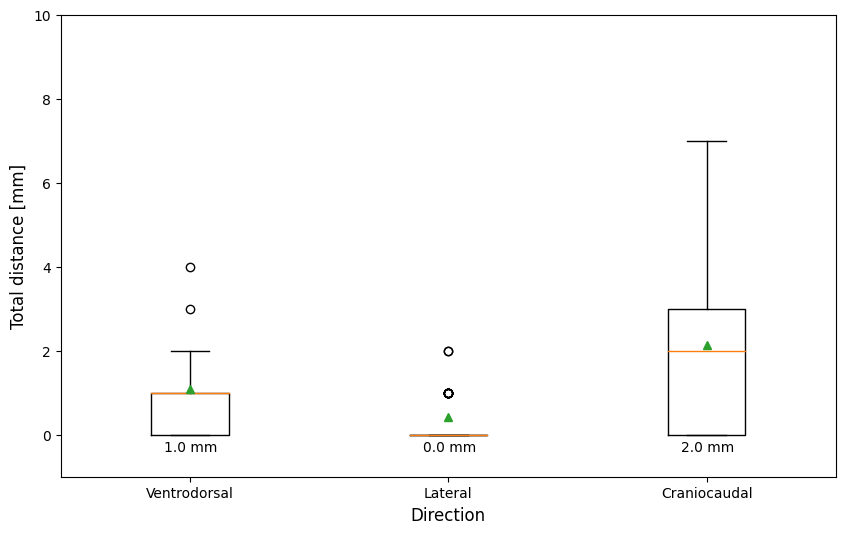

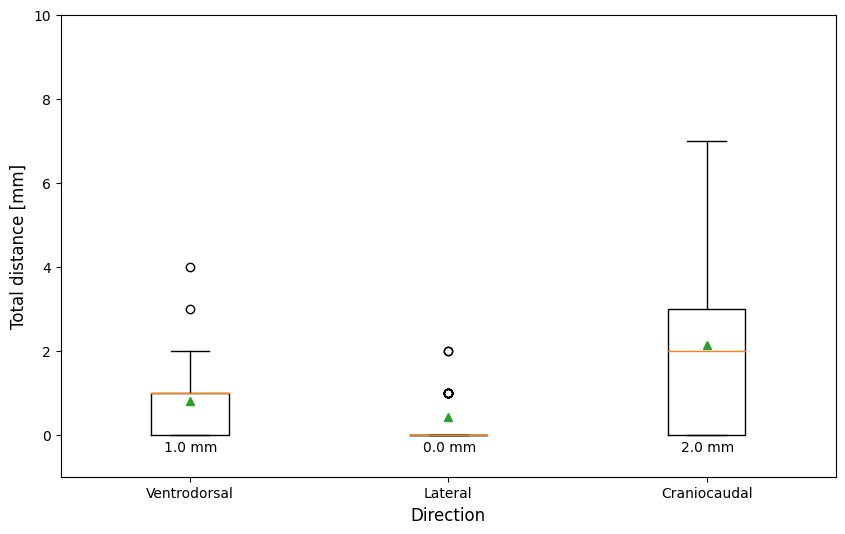

In [12]:
def plot_boxplot(datasets, labels, title=None, xlabel='Direction', ylabel="Total distance [mm]"):
    plt.figure(figsize=(10,6))
    plt.boxplot(datasets, labels=labels,showmeans=True)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.text(0.90,-0.3,str(np.round(np.median(datasets[0]),2))+" mm",va="center")
    plt.text(1.90,-0.3,str(np.round(np.median(datasets[1]),2))+" mm",va="center")
    plt.text(2.90,-0.3,str(np.round(np.median(datasets[2]),2))+" mm",va="center")
    plt.grid(False)
    plt.ylim([-1,10])
    #plt.show()
    plt.savefig('plot_boxplot.tiff', format='tiff', dpi=300)


plot_boxplot([hist_ventro,hist_lateral,hist_cranio], ['Ventrodorsal', 'Lateral', 'Craniocaudal'])
plot_boxplot([hist_ventro_true,hist_lateral_true,hist_cranio_true], ['Ventrodorsal', 'Lateral', 'Craniocaudal'])
